# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import holidays
from datetime import datetime, timezone
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, BinaryLogisticRegressionSummary
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Load Data

In [4]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())
spark.sparkContext.setLogLevel("ERROR") #supress warnings

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/17 17:00:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read in Dataset
df = spark.read.parquet("final_dataset_revised.parquet")
df.show(5)

+--------+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+
|Severity|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|
+--------+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+
|       2|         21|      85|      30|         1|        10|  

In [9]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7026806
DataFrame Columns count : 23


# Sampling

In [10]:
# Check Class Imbalance
cts = df.groupBy("Severity").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+--------+-------+------------------+
|Severity|  count|           percent|
+--------+-------+------------------+
|       1|  65142|0.9270499285165977|
|       3|1123799|15.993027272988611|
|       4| 178821|2.5448404296347444|
|       2|5659044| 80.53508236886005|
+--------+-------+------------------+



# Underperforming Tests Overview:

## Tried Random split (80/20)
- As predicted, model predicted severity = 2 for everything and they accuracy = the % of test samples with label = 2

train_data, test_data = df.randomSplit([0.8, 0.2])

## Undersampling (80/20) - undersampled each class by the smallest class for the training set - testing set everything else
- This decreased the training set to about 3.5% of the original data set and the accuracy (~32% reflected that)
- With undersampling, the performance might change with the sample taken

sample = (cts.select("count").rdd.min()[0])*0.8 #Undersample each class by 80% of the smallest class

class1 = sample/(cts.select("count").where(cts.Severity == '1').rdd.min()[0])

class2 = sample/(cts.select("count").where(cts.Severity == '2').rdd.min()[0])

class3 = sample/(cts.select("count").where(cts.Severity == '3').rdd.min()[0])

class4 = sample/(cts.select("count").where(cts.Severity == '4').rdd.min()[0])

df.createOrReplaceTempView("data_view") #Create a temporary view to use SQL

fractions = {1: class1, 2: class2, 3: class3, 4: class4} #downsample each class to 80% of the smallest class

train_data = df.sampleBy("Severity", fractions, seed=42) #Use stratified sampling to maintain class distribution

test_data = df.subtract(train_data)

## Did not try full Oversampling
- I'm always wary of oversampling amplyfying outliers especially with such high class imbalance and with regression trees that are already prone to overfitting
## A combination of oversampling and undersampling may be a nice compramise
- Did not check

## Binary Classification (1|2 = 0, 3|4 = 1)
- Best so far - model f1 score ~ 0.77 with base rf model - will obviously be better as half the options to guess from but still major improvement

features = df.select([col for col in df.columns if col != "Severity" and col != "Severity_Binary"]).columns # Select all features except target variable

assembler = VectorAssembler(inputCols=features, outputCol='features') # Vectorize Features

model = RandomForestClassifier(featuresCol = 'features', labelCol = 'Severity_Binary') # Model
  
pipeline = Pipeline(stages=[assembler, model]) # Creating the pipeline 

fit_model = pipeline.fit(train_data) #train

results = fit_model.transform(test_data) #predict

## Binary Classification

In [11]:
# Binary Classification (1 or 2 vs 3 or 4)
df = df.withColumn('Severity_Binary', when((col("Severity")==1) | (col("Severity")==2), 0).otherwise(1))
df = df.drop('Severity')
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|         21|      85|      30|         1| 

In [12]:
# Check Class Imbalance
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537867702623352|
|              0|5724186| 81.46213229737664|
+---------------+-------+------------------+



In [13]:
# Undersample each class by 80% of the smallest class
sample = (cts.select("count").rdd.min()[0])*0.8

class0 = sample/(cts.select("count").where(cts.Severity_Binary == '0').rdd.min()[0])
class1 = sample/(cts.select("count").where(cts.Severity_Binary == '1').rdd.min()[0])

# Split Data by Class - Downsampling

# Create a temporary view to use SQL
df.createOrReplaceTempView("data_view")

# Calculate fractions for each class
#fractions = df.groupBy("Severity").count().rdd.map(lambda row: (row[0], 0.8)).collectAsMap() #samples 80% of each class
fractions = {0: class0, 1: class1} #downsample each class to 80% of the smallest class

# Use stratified sampling to maintain class distribution
train_data = df.sampleBy("Severity_Binary", fractions, seed=42)
test_data = df.subtract(train_data)

In [13]:
# Print Overall % Sampled from DF
print(train_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
train_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / train_data.count())*100).show()

29.67241446540576
+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1041638|49.958105977727826|
|              0|1043385|50.041894022272174|
+---------------+-------+------------------+



In [14]:
# Print Overall % Sampled from DF
print(test_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
test_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / test_data.count())*100).show()

54.5318883145486


+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1| 233834|6.102378746558451|
|              0|3598016|93.89762125344156|
+---------------+-------+-----------------+



# Modeling

In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Select all features except target variable
feature_list = []
for col in df.columns:
    if col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)

features_list = ['Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weekday',
 'Rush Hour',
 #'Holiday',
 'Rain',
 'Snow',
 'SeasonVec',
 'SeasonVec2',
 'SeasonVec3',
 'Astronomical_TwilightIndex',
 'Interstate Indicator',
 'Sex ratio (males per 100 females)',
 'Percent_Age_15-19',
 'Percent_Age_20-24',
 'Percent_Age_65_over',
 'MedianIncome',
 'Urban_Ratio',
 'Traffic_Interference',
 'Traffic_Intersection',
 'Destination']       
        
# Vectorize Features
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

In [41]:
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

### Check for Multicollinearity

In [18]:
# Assemble features into a vector
df_vector = assembler.transform(df)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=features_list, index=features_list)

# Get the pairs of columns with correlation greater than 0.5
high_corr_pairs = []
for col1 in corr_matrix_pd.columns:
    for col2 in corr_matrix_pd.columns:
        if col1 != col2 and ((corr_matrix_pd[col1][col2] > 0.4) | (corr_matrix_pd[col1][col2] < -0.4)):
            high_corr_pairs.append((col1, col2, corr_matrix_pd[col1][col2]))

print(high_corr_pairs)

[('Temperature(F)', 'SeasonVec', -0.5175782168495072), ('SeasonVec', 'Temperature(F)', -0.5175782168495072), ('Percent_Age_15-19', 'Percent_Age_20-24', 0.46583032647265293), ('Percent_Age_20-24', 'Percent_Age_15-19', 0.46583032647265293), ('Percent_Age_20-24', 'Percent_Age_65_over', -0.40007330340669495), ('Percent_Age_65_over', 'Percent_Age_20-24', -0.40007330340669495)]


# Sensitivity Testing

In [51]:
#Features Column
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Define parameter ranges
param_ranges = {
    "maxDepth": [3,4],
    "maxIter": [3,4]
}

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction")

# Perform sensitivity analysis
results = []
for maxDepth in param_ranges["maxDepth"]:
    for maxIter in param_ranges["maxIter"]:
        # Create a logistic regression model
        gbt = GBTClassifier(labelCol="Severity_Binary", featuresCol="features", maxDepth=maxDepth, maxIter=maxIter)

        # Fit the model
        model = gbt.fit(train_data)

        # Make predictions
        predictions = model.transform(test_data)

        # Evaluate the model
        recall = evaluator.evaluate(predictions, {evaluator.metricName:"truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        f1 = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
        accuracy = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

        # Store the results
        results.append((maxDepth, maxIter, recall, f1, accuracy))

# Analyze the results
for result in results:
    print(result)

(3, 3, 0.46769075498002854, 0.8467884270366937, 0.8030794524837872)


In [23]:
# Create a RandomForestClassifier
rf = GBTClassifier(labelCol="Severity_Binary", featuresCol="features")
# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxIter, [3, 6]) \
    .addGrid(rf.maxDepth, [3, 4]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Severity_Binary"
                                                                      , predictionCol="prediction"
                                                                      , metricName="weightedRecall"),
                          numFolds=2,
                          collectSubModels=True)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions on the test set
predictions = cvModel.transform(test_data)

# Evaluate the model
#evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall: ", recall)

# Get and save the best model
bestModel = cvModel.bestModel
bestModel.save("best_gbt_model")
print(bestModel.stages[-1]._java_obj.paramMap()) 

Recall:  0.6917945639834545


24/11/17 17:12:45 ERROR Instrumentation: java.io.IOException: Path best_gbt_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at or

Py4JJavaError: An error occurred while calling o7026.save.
: java.io.IOException: Path best_gbt_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


## Load Saved Best Model

In [19]:
# Load the saved best model
loadedCvModel = PipelineModel.load("best_gbt_model")

## Evaluation Metrics

Weighted Precision: 0.9158746279358325
Weighted Recall: 0.6931749574325194
Weighted F1 Score: 0.7730147581077779
Accuracy: 0.6931749574325196


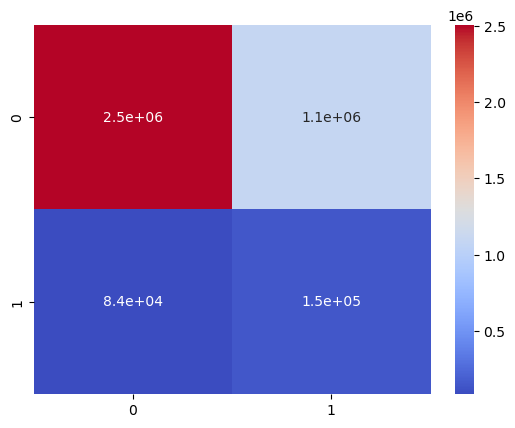

Area Under ROC: 0.6681312059814621


In [20]:
# Further Metrics on Best Model
pred = loadedCvModel.transform(test_data)

#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
predictionAndLabels = pred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Get precision, recall, and F1-score for each class
print(f'Weighted Precision: {multi_metrics.weightedPrecision}') #would expect to be good when test sample has high majority 0 class
print(f'Weighted Recall: {multi_metrics.weightedRecall}')
print(f'Weighted F1 Score: {multi_metrics.weightedFMeasure()}') #would like to optimize this (balance of precision and recall)
print(f'Accuracy: {multi_metrics.accuracy}') #could be skewed with imbalanced test set

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()

# AUC Score
binary_metrics = BinaryClassificationMetrics(rdd)
auc = binary_metrics.areaUnderROC
print("Area Under ROC:", auc)

## Feature Importance

In [50]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances

# Create a mapping between feature names and their importance scores
feature_importance_dict = {}
feature_names = assembler.getInputCols()
for i, feature_name in enumerate(feature_names):
    feature_importance_dict[feature_name] = feature_importances[i]

# Sort the feature importance dictionary by score in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature_name, importance_score in sorted_feature_importances:
    print(f"{feature_name}: {importance_score}")

Percent_Age_15-19: 0.6538633098522804
Wind_Speed(mph): 0.11309523586636983
Pressure(in): 0.021411067760803683
Urban_Ratio: 0.020182736604989756
Traffic_Intersection: 0.01307051332883975
Sex ratio (males per 100 females): 0.006172481797186255
Temperature(F): 0.00493695556091131
Traffic_Interference: 0.004705629286118825
Visibility(mi): 0.0035782185663899894
Destination: 0.0030973008775653
Weekday: 0.0026137961573831966
Percent_Age_65_over: 0.0024557402387279104
Snow: 0.0020169011529076507
MedianIncome: 0.0013424964805030298
Percent_Age_20-24: 0.0008952325602054058
Humidity(%): 0.00013728881673452133
Rush Hour: 3.356935485804044e-05
Precipitation(in): 0.0
Holiday: 0.0
Rain: 0.0
SeasonVec: 0.0
Astronomical_TwilightIndex: 0.0
Interstate Indicator: 0.0


# Questions/Wierd Things

In [ ]:
#Why is my undersampling code not using all available data?

#Can't figure out ROC Curve

In [ ]:
#Feature Importances
bestModel = cvModel.bestModel.stages[-1]  # Assuming the last stage in the pipeline is the model

featureImportances = bestModel.featureImportances

print("Feature Importances:")
for feature, importance in zip(test_data.columns[:-1], featureImportances):
    print(f"{feature}: {importance}")

Feature Importances:
Temperature(F): 0.0009213015483506297
Humidity(%): 0.002540609439652656
Pressure(in): 0.020450333607135187
Visibility(mi): 0.0013161062441105088
Wind_Speed(mph): 0.0940699616214557
Precipitation(in): 0.0
Weekday: 0.0005017290970311592
Rush Hour: 0.0
Holiday: 0.0
Rain: 0.0023240584289040468
Snow: 0.0
SeasonVec: 0.0
Astronomical_TwilightIndex: 0.0
Interstate Indicator: 0.0
Sex ratio (males per 100 females): 0.0
Percent_Age_15-19: 0.7070260166982979
Percent_Age_20-24: 0.0002243347183741944
Percent_Age_65_over: 0.0
MedianIncome: 0.003956996597709727
Urban_Ratio: 0.0
Traffic_Interference: 0.01904514582410056
Traffic_Intersection: 0.0169767010785899
Destination: 0.0


In [31]:
bestModel.featureImportances #why are there 25? when only 23 features? Onehotencoding?

SparseVector(25, {0: 0.0009, 1: 0.0025, 2: 0.0205, 3: 0.0013, 4: 0.0941, 6: 0.0005, 9: 0.0023, 15: 0.707, 16: 0.0002, 18: 0.004, 20: 0.019, 21: 0.017, 23: 0.1054, 24: 0.0253})